In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch import Tensor

class HardDistillationLoss(nn.Module):
    def __init__(self, teacher: nn.Module):
        super().__init__()
        self.teacher = teacher
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, inputs: Tensor, outputs: tuple[Tensor, Tensor], labels: Tensor) -> Tensor:
        outputs_cls, outputs_dist = outputs

        # Базовая потеря (CLS)
        base_loss = self.criterion(outputs_cls, labels)

        # Вычисляем предсказания учителя
        with torch.no_grad():
            teacher_outputs = self.teacher(inputs)

        # Ограничиваем выходы учителя двумя классами
        teacher_logits = teacher_outputs[:, :2]  # Берем только первые два класса
        teacher_labels = torch.argmax(teacher_logits, dim=1)

        # Потеря для DIST
        teacher_loss = self.criterion(outputs_dist, teacher_labels)

        # Комбинируем потери
        return 0.5 * base_loss + 0.5 * teacher_loss

In [2]:
from typing import Union

class HardDistillationLoss(nn.Module):
    def __init__(self, teacher: nn.Module):
        super().__init__()
        self.teacher = teacher
        self.criterion = nn.CrossEntropyLoss()
        
    def forward(self, inputs: Tensor, outputs: Union[Tensor, Tensor], labels: Tensor) -> Tensor:
        outputs_cls, outputs_dist = outputs
        base_loss = self.criterion(outputs_cls, labels)

        with torch.no_grad():
            teacher_outputs = self.teacher(inputs)
        teacher_labels = torch.argmax(teacher_outputs, dim=1)
        teacher_loss = self.criterion(outputs_dist, teacher_labels)
        
        return 0.5 * base_loss + 0.5 * teacher_loss

In [5]:
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce

class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768, img_size: int = 224):
        super().__init__()
        self.patch_size = patch_size

        # Проекция патчей
        self.projection = nn.Sequential(
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )

        # Токены CLS и DIST
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size))
        self.dist_token = nn.Parameter(torch.randn(1, 1, emb_size))  # Убедитесь, что это определено

        # Позиционные эмбеддинги
        num_patches = (img_size // patch_size) ** 2
        self.positions = nn.Parameter(torch.randn(num_patches + 2, emb_size))  # +2 для cls_token и dist_token

    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape

        # Проекция патчей
        x = self.projection(x)

        # Создание токенов CLS и DIST
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        dist_tokens = repeat(self.dist_token, '() n e -> b n e', b=b)

        # Добавление токенов CLS и DIST к входным данным
        x = torch.cat([cls_tokens, dist_tokens, x], dim=1)

        # Добавление позиционных эмбеддингов
        x += self.positions

        return x

In [6]:
class ClassificationHead(nn.Module):
    def __init__(self, emb_size: int = 768, n_classes: int = 2):       
        super().__init__()

        self.head = nn.Linear(emb_size, n_classes)
        self.dist_head = nn.Linear(emb_size, n_classes)

    def forward(self, x: Tensor) -> Tensor:
        x, x_dist = x[:, 0], x[:, 1]
        x_head = self.head(x)
        x_dist_head = self.dist_head(x_dist)
        
        if self.training:
            x = x_head, x_dist_head  # Возвращает кортеж
        else:
            x = (x_head + x_dist_head) / 2  # Возвращает тензор
        return x

In [9]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 768, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        # fuse the queries, keys and values in one matrix
        self.qkv = nn.Linear(emb_size, emb_size * 3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        
    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values in num_heads
        qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3)
        queries, keys, values = qkv[0], qkv[1], qkv[2]
        # sum up over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
            
        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out
    
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
        
    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x
    
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size: int, expansion: int = 4, drop_p: float = 0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )
        
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size: int = 768,
                 drop_p: float = 0.,
                 forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 ** kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))

class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int = 12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])

In [11]:
class DeiT(nn.Sequential):
    def __init__(self,     
                in_channels: int = 3,
                patch_size: int = 16,
                emb_size: int = 768,
                img_size: int = 224,
                depth: int = 12,
                n_classes: int = 1000,
                **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes))

In [13]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Определение преобразований для изображений
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Изменяем размер до 224x224
    transforms.ToTensor(),          # Преобразуем в тензор
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Нормализация
])

# Создание датасета с помощью ImageFolder
ds = datasets.ImageFolder(root='Testing', transform=transform)

# Создание DataLoader
dl = DataLoader(ds, batch_size=32, shuffle=False)

print(ds.classes)  # ['tumor', 'no_tumor']
print(len(ds))

['Brain Tumor', 'Healthy']
6161


In [69]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Hook для сохранения градиентов и активаций
        target_layer.register_forward_hook(self.save_activations)
        target_layer.register_backward_hook(self.save_gradients)

    def save_activations(self, module, input, output):
        self.activations = output.detach()

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def forward(self, x, class_idx=None):
        # Сохраняем исходные размеры изображения
        original_size = x.shape[-2:]  # (height, width)
        h, w = original_size
    
        # Проверка, что размеры корректны
        if h <= 0 or w <= 0:
            raise ValueError(f"Некорректные размеры изображения: height={h}, width={w}")
    
        # Прямой проход через модель
        logits = self.model(x)
        if isinstance(logits, tuple):
            logits = logits[0]  # Берём первый выход (CLS)
        self.model.zero_grad()
    
        if class_idx is None:
            class_idx = logits.argmax(dim=1).item()
    
        one_hot = torch.zeros_like(logits)
        one_hot[0][class_idx] = 1
        one_hot.requires_grad_(True)
    
        # Вычисляем градиенты относительно one_hot
        output = (one_hot * logits).sum()
        output.backward(retain_graph=True)
    
        gradients = self.gradients.cpu().numpy()[0]
        activations = self.activations.cpu().numpy()[0]
    
        weights = np.mean(gradients, axis=(1, 2))
        cam = np.zeros(activations.shape[1:], dtype=np.float32)
    
        for i, w in enumerate(weights):
            cam += w * activations[i]
    
        cam = np.maximum(cam, 0)
    
        # Проверка размеров перед изменением размера
        if int(w) <= 0 or int(h) <= 0:
            raise ValueError(f"Некорректные размеры для изменения размера: w={w}, h={h}")
        cam = cv2.resize(cam, (int(w), int(h)))  # Преобразуем w и h в целые числа
    
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
    
        return cam

    def __call__(self, x, class_idx=None):
        return self.forward(x, class_idx)

In [17]:
import matplotlib
from torch.optim import Adam #
import timm
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score  # Импортируем метрики
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

train_losses = []
train_accuracies = []
train_f1_scores = []
train_auc_scores = []

print('1')

# Teacher model (Vision Transformer)
teacher = timm.create_model('vit_large_patch16_224', pretrained=True, num_classes=2)
teacher.eval()

# Student model (DeiT)
student = timm.create_model('deit_small_patch16_224', pretrained=True, num_classes=2)

# teacher = ViT.vit_large_patch16_224()
# student = DeiT.deit_small_patch16_224()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Создание датасета

# ds = datasets.ImageFolder(
#     root='archive-4',
#     transform=transform,
#     target_transform=lambda x: 0 if ds.classes[x] == 'tumor' else 1
# )
ds = datasets.ImageFolder(root='Testing', transform=transform)

# print("Классы:", ds.classes)
# print("Пример первого элемента:", ds[0])  # Должен быть кортеж (image_tensor, label)

# Создание DataLoader
dl = DataLoader(ds, batch_size=32, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
teacher.to(device)

dummy_input = torch.randn(1, 3, 224, 224).to(device)
output = teacher(dummy_input)
print(output.shape)  # Должно быть torch.Size([1, 2])
print("Выход учителя:", teacher(torch.randn(1, 3, 224, 224).to(device)).shape)



student = DeiT(
    in_channels=3,
    patch_size=16,
    emb_size=384,
    img_size=224,
    depth=12,
    n_classes=2  # Два класса
)

# Оптимизатор
optimizer = Adam(student.parameters(), lr=0.001)

# Функция потерь
criterion = HardDistillationLoss(teacher)

# Цикл обучения

teacher.to(device)
student.to(device)

# Цикл обучения
try:
    for epoch in range(5):
        student.train()
        running_loss = 0.0
        all_labels, all_preds, all_probs = [], [], []
        
        for batch in tqdm(dl, desc=f"Epoch {epoch+1}/5"):
            # Извлекаем данные
            inputs, labels = batch  # <-- Проверьте, что здесь 2 элемента
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            # Прямой проход
            outputs = student(inputs)
            if isinstance(outputs, tuple):
                outputs_cls, outputs_dist = outputs
            else:
                outputs_cls = outputs
                outputs_dist = outputs
            
            # Вычисляем потери
            loss = criterion(inputs, (outputs_cls, outputs_dist), labels)
            
            # Обратное распространение
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # Собираем метрики
            probs = torch.softmax(outputs_cls, dim=1).detach().cpu().numpy()
            preds = probs.argmax(axis=1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds)
            all_probs.extend(probs[:, 1])

        # Вычисляем метрики
        epoch_loss = running_loss / len(dl)
        epoch_acc = accuracy_score(all_labels, all_preds)
        epoch_f1 = f1_score(all_labels, all_preds)
        epoch_auc = roc_auc_score(all_labels, all_probs)

        # Сохраняем метрики
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        train_f1_scores.append(epoch_f1)
        train_auc_scores.append(epoch_auc)

        print(f"Epoch {epoch+1}/5 | Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, F1: {epoch_f1:.4f}, AUC: {epoch_auc:.4f}")

except Exception as e:
    print("Ошибка:", e)

print('3')

1
torch.Size([1, 2])
Выход учителя: torch.Size([1, 2])


Epoch 1/5: 100%|██████████████████████████████| 193/193 [45:09<00:00, 14.04s/it]


Epoch 1/5 | Loss: 0.5650, Acc: 0.5360, F1: 0.4908, AUC: 0.5459


Epoch 2/5: 100%|██████████████████████████████| 193/193 [39:45<00:00, 12.36s/it]


Epoch 2/5 | Loss: 0.3614, Acc: 0.5739, F1: 0.5100, AUC: 0.5966


Epoch 3/5: 100%|██████████████████████████████| 193/193 [38:43<00:00, 12.04s/it]


Epoch 3/5 | Loss: 0.3665, Acc: 0.5512, F1: 0.4839, AUC: 0.5598


Epoch 4/5: 100%|██████████████████████████████| 193/193 [40:07<00:00, 12.47s/it]


Epoch 4/5 | Loss: 0.3927, Acc: 0.5657, F1: 0.5092, AUC: 0.5757


Epoch 5/5: 100%|██████████████████████████████| 193/193 [41:55<00:00, 13.03s/it]

Epoch 5/5 | Loss: 0.3592, Acc: 0.5921, F1: 0.5442, AUC: 0.6156
3


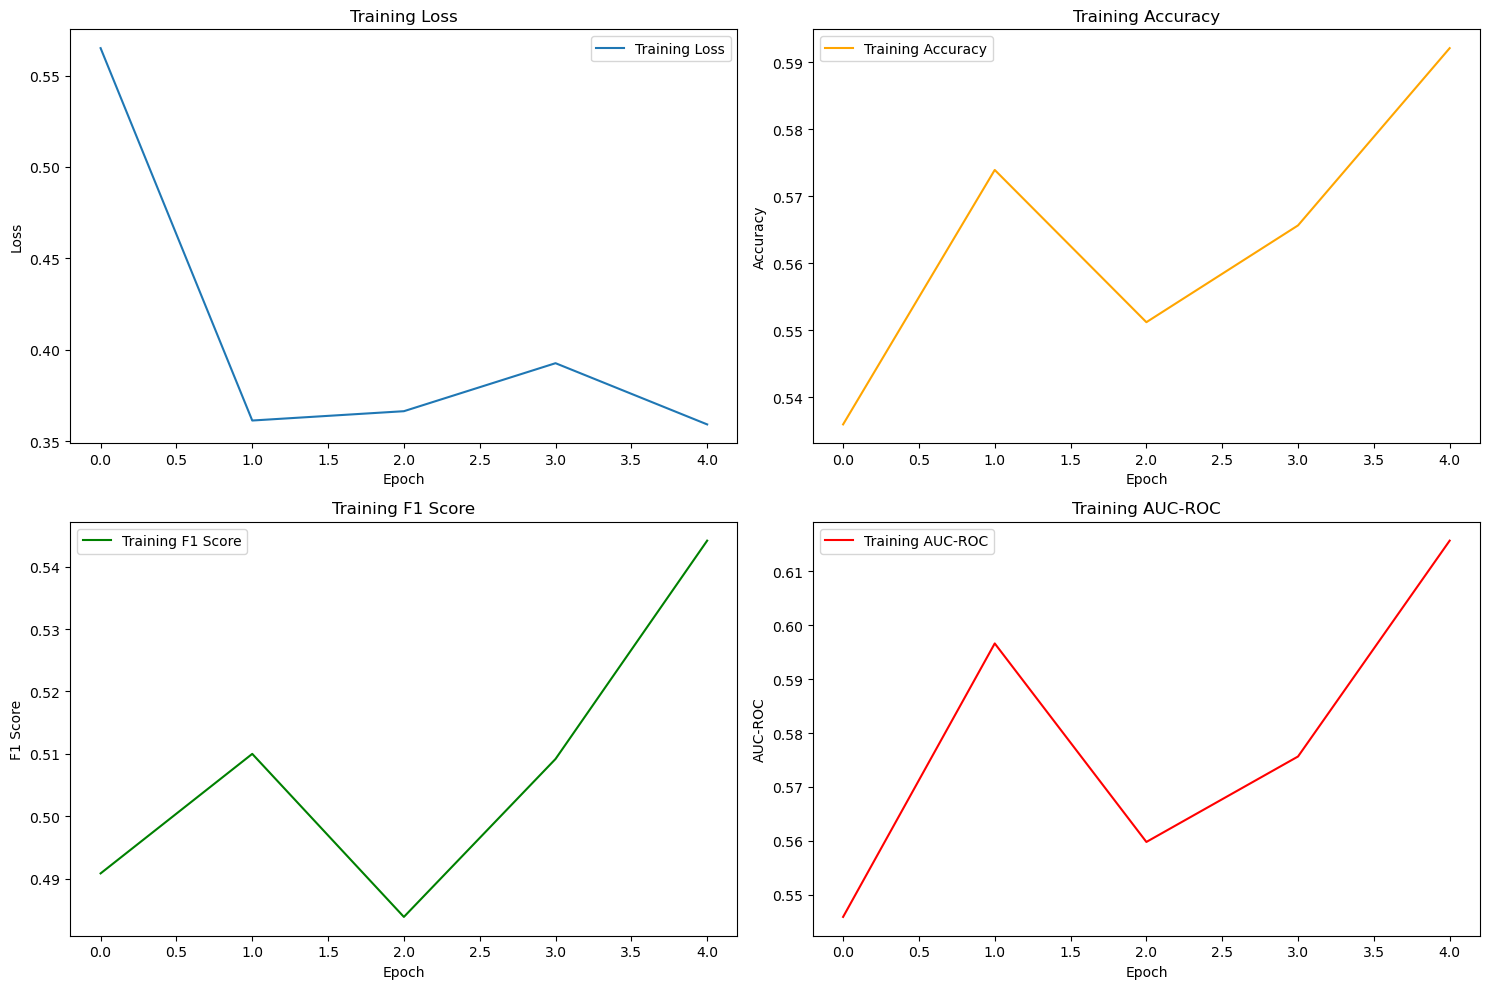

In [21]:
import matplotlib.pyplot as plt

# Преобразование списков метрик в массивы NumPy
loss = [l.detach().cpu().item() if isinstance(l, torch.Tensor) else l for l in train_losses]
train_accuracies = [acc.detach().cpu().item() if isinstance(acc, torch.Tensor) else acc for acc in train_accuracies]
train_f1_scores = [f1.detach().cpu().item() if isinstance(f1, torch.Tensor) else f1 for f1 in train_f1_scores]
train_auc_scores = [auc.detach().cpu().item() if isinstance(auc, torch.Tensor) else auc for auc in train_auc_scores]

# Построение графиков
plt.figure(figsize=(15, 10))

# График потерь
plt.subplot(2, 2, 1)
plt.plot(loss, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# График точности
plt.subplot(2, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='orange')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# График F1-меры
plt.subplot(2, 2, 3)
plt.plot(train_f1_scores, label='Training F1 Score', color='green')
plt.title('Training F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

# График AUC-ROC
plt.subplot(2, 2, 4)
plt.plot(train_auc_scores, label='Training AUC-ROC', color='red')
plt.title('Training AUC-ROC')
plt.xlabel('Epoch')
plt.ylabel('AUC-ROC')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
def visualize_cam(image, cam, title="Grad-CAM"):
    """Отображение исходного изображения и тепловой карты."""
    image = image.permute(1, 2, 0).cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = heatmap.astype(np.float32) / 255
    overlay = image + heatmap
    overlay = overlay / overlay.max()

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(image)
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    ax[1].imshow(heatmap)
    ax[1].set_title("Heatmap")
    ax[1].axis("off")

    ax[2].imshow(overlay)
    ax[2].set_title(title)
    ax[2].axis("off")
    plt.show()

# Выбираем случайные изображения из тестового датасета
student.eval()
with torch.no_grad():
    sample_images = []
    sample_labels = []
    for i in range(5):  # Выбираем 5 случайных изображений
        idx = np.random.randint(len(ds))
        img, label = ds[idx]
        sample_images.append(img)
        sample_labels.append(label)

# Применяем Grad-CAM к выбранным изображениям
target_layer = student[0].projection[0]  # Целевой слой для Grad-CAM
grad_cam = GradCAM(student, target_layer)

for img, label in zip(sample_images, sample_labels):
    img = img.unsqueeze(0).to(device)
    cam = grad_cam(img)
    visualize_cam(img.squeeze(0), cam, title=f"Label: {label}")

In [40]:
# Сохранение модели
model_save_path = "student_model.pth"  # Укажите путь и имя файла

# Если вы хотите сохранить только веса модели:
torch.save(student.state_dict(), model_save_path)

print(f"Модель успешно сохранена в файл: {model_save_path}")

Модель успешно сохранена в файл: student_model.pth
